### created by Takuya Matsuda at YNU

In [18]:
!pip install graphviz

<br><br>
# Explainable k-means

In [30]:
import queue
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from graphviz import Digraph

<br><br>
## Define funcs for k=2
I did not create Class of their algorithm, so this is a little experiment for me.

In [2]:
#ソートと動的計画法によって，最適な分割を求める (k=2)
#this func is main func and get best split condition using sort and dynamic programming
def optimal_threshold_2means(X):
    bests_split = {'cost':np.inf,'coordinate':None,'threshold':None}
    data_num = X.shape[0]
    data_dimentions = X.shape[1]
    u = np.sum(X*X)
    
    for i in range(data_dimentions):
        s = np.zeros(data_dimentions)
        r = np.sum(X,axis=0)
        ith_sorted_X = X[X[:,i].argsort(), :]
        for j,data in enumerate(ith_sorted_X[:-1]):
            s += data
            r -= data
            cost = u - np.sum(s*s)/(j+1) -np.sum(r*r)/(data_num-j-1)
            #print(cost)
            if cost < bests_split['cost'] and X[j][i]!=X[j+1][i]:
                bests_split['cost'] = cost
                bests_split['coordinate'] = i
                bests_split['threshold'] = data[i]
            
    return bests_split

#最適な分割に基づいてクラスタリング(k=2)
#this func is for clustering datasets based on best splits got from above func
def clustering_2means_by_tree(bests_split,X):
    cluster = np.ones(X.shape[0])
    for i,data in enumerate(X):
        if(data[bests_split['coordinate']]>bests_split['threshold']):
            cluster[i] = 0
    return cluster

#得られた分割の中心座標を求める(k=2)
#this func is for calculating center points
def get_mean(X,approx_labels):
    res=[]
    for k in range(len(np.unique(approx_labels))):
        n = 0
        mean = np.zeros(X.shape[1])
        for i,data in enumerate(X):
            if(approx_labels[i]==k):
                mean+=data
                n+=1
        res.append(mean/n)
    return np.array(res)

#近似の比率を計算する，論文ではkmeansの場合，上界は4である(k=2)．
#this func is for calculating approximation ratio
def approx_score(approx_labels,kmeans_model,X):
    kmeans_cost = 0
    kmeans_label = kmeans_model.labels_
    kmeans_centers = kmeans_model.cluster_centers_
    for i,data in enumerate(X):
        kmeans_cost += np.sum((data-kmeans_centers[kmeans_label[i]])*(data-kmeans_centers[kmeans_label[i]]))
    
    approx_cost = 0
    mean = get_mean(X,approx_labels)
    for k in range(kmeans_model.n_clusters):
        for i,data in enumerate(X):
            if(approx_labels[i]==k):
                approx_cost += np.sum((data-mean[k])*(data-mean[k]))
    print(kmeans_cost)
    print(approx_cost)
    return approx_cost/kmeans_cost

<br><br>
## Two Datasets
First is from [this good article](https://qiita.com/ynakayama/items/1223b6844a1a044e2e3b).

Second is from uci repo and I get the code from [this good article](https://pythondatascience.plavox.info/scikit-learn/%E3%82%AF%E3%83%A9%E3%82%B9%E3%82%BF%E5%88%86%E6%9E%90-k-means).

In [3]:
# First dataset
# 生徒の国語・数学・英語の各得点を配列として与える
X = np.array([
        [  80,  85, 100 ],
        [  96, 100, 100 ],
        [  54,  83,  98 ],
        [  80,  98,  98 ],
        [  90,  92,  91 ],
        [  84,  78,  82 ],
        [  79, 100,  96 ],
        [  88,  92,  92 ],
        [  98,  73,  72 ],
        [  75,  84,  85 ],
        [  92, 100,  96 ],
        [  96,  92,  90 ],
        [  99,  76,  91 ],
        [  75,  82,  88 ],
        [  90,  94,  94 ],
        [  54,  84,  87 ],
        [  92,  89,  62 ],
        [  88,  94,  97 ],
        [  42,  99,  80 ],
        [  70,  98,  70 ],
        [  94,  78,  83 ],
        [  52,  73,  87 ],
        [  94,  88,  72 ],
        [  70,  73,  80 ],
        [  95,  84,  90 ],
        [  95,  88,  84 ],
        [  75,  97,  89 ],
        [  49,  81,  86 ],
        [  83,  72,  80 ],
        [  75,  73,  88 ],
        [  79,  82,  76 ],
        [ 100,  77,  89 ],
        [  88,  63,  79 ],
        [ 100,  50,  86 ],
        [  55,  96,  84 ],
        [  92,  74,  77 ],
        [  97,  50,  73 ],
        ])

In [4]:
#second datasets
cust_df = pd.read_csv("http://pythondatascience.plavox.info/wp-content/uploads/2016/05/Wholesale_customers_data.csv")
del(cust_df['Channel'])
del(cust_df['Region'])
cust_array = np.array([cust_df['Fresh'].tolist(),
                       cust_df['Milk'].tolist(),
                       cust_df['Grocery'].tolist(),
                       cust_df['Frozen'].tolist(),
                       cust_df['Milk'].tolist(),
                       cust_df['Detergents_Paper'].tolist(),
                       cust_df['Delicassen'].tolist()
                       ], np.int32)
cust_array = cust_array.T
cust_array.shape

(440, 7)

<br><br>
## First data and k=2 

In [5]:
#K-meansクラスタリングをおこなう
kmeans_model = KMeans(n_clusters=2, random_state=10).fit(X)
#分類先となったラベルを取得する
labels = kmeans_model.labels_

#提案手法による近似アルゴリズムで取得する
bests_split = optimal_threshold_2means(X)
approx_labels = clustering_2means_by_tree(bests_split,X)
print(bests_split)
print(approx_labels)

{'cost': 11316.030172413797, 'coordinate': 0, 'threshold': 70}
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


In [6]:
approx_score(approx_labels,kmeans_model,X) #近似アルゴリズムのコスト ➗ k-meansのコスト

11316.030172413793
11316.030172413793


1.0

<br><br>
## Second data and k=2

In [7]:
#K-meansクラスタリングをおこなう
kmeans_model = KMeans(n_clusters=2, random_state=10).fit(cust_array)
#分類先となったラベルを取得する
labels = kmeans_model.labels_

#提案手法による近似アルゴリズムで取得する
bests_split = optimal_threshold_2means(cust_array)
approx_labels = clustering_2means_by_tree(bests_split,cust_array)
print(bests_split)

{'cost': 41288343652.5358, 'coordinate': 2, 'threshold': 16483}


In [8]:
approx_score(approx_labels,kmeans_model,cust_array) #近似アルゴリズムのコスト ➗ k-meansのコスト

132340344661.33641
135777624164.53575


1.0259730281948067

<br><br>
## IMM Algorithm
I'm working on this....

## Define funcs
I did not create Class of their algorithm, so this is a little experiment for me.

In [110]:
class TreeNode:
    def __init__(self, cluster=None, left=None, right=None,condition=None):
        self.cluster = cluster
        self.left = left
        self.right = right 
        self.condition = (0,0) #(i,threshold) x_i <= threshold  or  x_i > threshold 

def minimum_center(i,labels,centers):
    minimum = np.inf
    for j in labels:
        minimum = min(minimum, centers[j][i])
    return minimum

def maximum_center(i,labels,centers):
    maximum = -np.inf
    for j in labels:
        maximum = max(maximum, centers[j][i])
    return maximum  

def mistake(x,center,i,threshold):
    return 0 if ((x[i]<=threshold) == (center[i]<=threshold)) else 1

def delete_mistakes_data(X,labels,centers,i,threshold):
    new_data = []
    new_labels=[]
    for idx,x in enumerate(X):
        if(mistake(x,centers[labels[idx]],i,threshold)==0):
            new_data.append(x)
            new_labels.append(labels[idx])
    return np.array(new_data),np.array(new_labels)
    
def make_next_data(X,labels,i,threshold):
    l_data=[]
    l_labels=[]
    r_data=[]
    r_labels=[]
    for idx,x in enumerate(X):
        if(x[i]<=threshold):
            l_data.append(x)
            l_labels.append(labels[idx])
        else:
            r_data.append(x)
            r_labels.append(labels[idx])
            
    return np.array(l_data),np.array(l_labels),np.array(r_data),np.array(r_labels)

def count_mistakes(X,l,i,labels,centers):
    cnt=0
    for idx,x in enumerate(X):
        if(mistake(x,centers[labels[idx]],i,l[i])==1):
            cnt+=1
    return cnt

def get_best_splits(X,l,r,labels,centers):
    bests_split = {'mistake':np.inf,'coordinate':None,'threshold':None}
    data_dimentions = X.shape[1]
    
    for i in range(data_dimentions):
        ith_sorted_X = X[X[:,i].argsort(), :]
        ith_sorted_centers = centers[centers[:,i].argsort(), :]
        idx_center = 1
        cnt_mistakes = count_mistakes(X,l,i,labels,centers)
        for j,x in enumerate(ith_sorted_X[:-1]):
            if(l[i]>x[i] or x[i]>=r[i]):
                continue
                
            cnt_mistakes = count_mistakes(X,x,i,labels,centers) #ここで本来はDPでより効率よく計算すべきだが，やり方がよくわからない．なのでナイーブなやり方でやっている．つまり，全データに対してその分割でmistakeとなるのか否かを調べている
            
            if bests_split['mistake'] > cnt_mistakes:
                bests_split['mistake'] = cnt_mistakes
                bests_split['coordinate'] = i
                bests_split['threshold'] = x[i]   
    print("num of mistakes at this node => {}".format(bests_split['mistake']))
    return bests_split['coordinate'],bests_split['threshold']

def build_tree(X,labels,centers):
    node = TreeNode()
    l=[]
    r=[]
    
    #論文疑似コード ２〜４行目
    if(len(np.unique(labels))==1):
        node.cluster = labels[0]
        return node

    #論文疑似コード ６〜９行目
    for i in range(X.shape[1]):
        l.append(minimum_center(i,labels,centers))
        r.append(maximum_center(i,labels,centers))

    #論文疑似コード 10〜13行目
    i,threshold = get_best_splits(X,l,r,labels,centers)
    X,labels = delete_mistakes_data(X,labels,centers,i,threshold)
    left_data,left_labels,right_data,right_labels = make_next_data(X,labels,i,threshold)
    
    #論文疑似コード １４〜１６行目
    node.condition = (i,threshold)
    node.left = build_tree(left_data,left_labels,centers)
    node.right = build_tree(right_data,right_labels,centers)
    
    return node

<br><br>
## First data and k=3

num of mistakes at this node => 1
num of mistakes at this node => 2


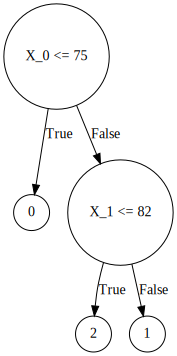

In [122]:
#IMM procedure
kmeans_model = KMeans(n_clusters=3, random_state=10).fit(X)
centers = kmeans_model.cluster_centers_
labels = kmeans_model.labels_
root = build_tree(X,labels,centers)
make_tree(root,kmeans_model.n_clusters)

⇩クラスタ0におけるmistakeは1つだけ

In [106]:
labels[X[:,0] <= 75]

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], dtype=int32)

⇩クラスタ2におけるmistakeはない(0は考えなくて良い)．

In [104]:
labels[X[:,1] <= 82]

array([2, 2, 2, 0, 2, 0, 0, 0, 2, 0, 2, 2, 2, 2, 2, 2], dtype=int32)

⇩クラスタ1におけるmistakeは2つ

In [105]:
labels[X[:,1] > 82]

array([1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 2, 1, 0, 0, 2, 1, 1, 1, 0],
      dtype=int32)

<br><br>
## Second data and k=3

num of mistakes at this node => 8
num of mistakes at this node => 11


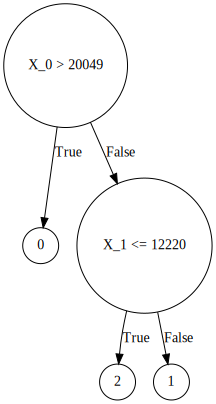

In [125]:
#IMM procedure
kmeans_model = KMeans(n_clusters=3, random_state=10).fit(cust_array)
centers = kmeans_model.cluster_centers_
labels = kmeans_model.labels_

root = build_tree(cust_array,labels,centers)
make_tree(root,kmeans_model.n_clusters)

In [126]:
labels[cust_array[:,0] > 20049]

array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 2, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [131]:
labels[cust_array[:,1] <= 12220]

array([2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2, 0,
       0, 2, 2, 2, 0, 2, 2, 0, 0, 2, 2, 0, 2, 0, 0, 2, 2, 1, 2, 2, 2, 2,
       0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2,
       2, 2, 2, 2, 2, 0, 2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0,
       2, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 1, 2, 2, 2,
       0, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2,
       2, 2, 0, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 0, 0, 2, 2, 0, 0, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2,
       2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 0, 2, 2, 2, 2,
       0, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 0, 2, 2, 2, 2, 2, 0, 1, 2, 0, 2, 2, 2,

In [128]:
labels[cust_array[:,1] > 12220]

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 1, 0, 1, 1, 2, 1, 1, 0, 1],
      dtype=int32)

<br><br>
func for visualization  
sorry for dirty code...

In [124]:
def make_tree(root,n_clusters):
  G = Digraph(format='png')
  G.attr('node', shape='circle')
  N = 2*n_clusters - 1 #ノード数
  
  q = queue.Queue()
  q.put(root)
  if(root.right.cluster != None):
    G.node(str(0),"X_{} > {}".format(root.condition[0],root.condition[1]))
  else:
    G.node(str(0),"X_{} <= {}".format(root.condition[0],root.condition[1]))
  i=1
  while not q.empty():
    root = q.get()

    if root.left.cluster != None and root.right.cluster != None:
      G.node(str(i), str(root.left.cluster))
      G.edge(str(i-1), str(i),label='True')
      G.node(str(i+1), str(root.right.cluster))
      G.edge(str(i-1), str(i+1),label='False')      
    elif root.right.cluster != None:
      G.node(str(i), str(root.right.cluster))
      G.edge(str(i-1), str(i),label='True')
      G.node(str(i+1),"X_{} <= {}".format(root.left.condition[0],root.left.condition[1]))
      G.edge(str(i-1), str(i+1),label='False')
      q.put(root.left)
    else:
      G.node(str(i), str(root.left.cluster))
      G.edge(str(i-1), str(i),label='True')
      G.node(str(i+1),"X_{} <= {}".format(root.right.condition[0],root.right.condition[1]))
      G.edge(str(i-1), str(i+1),label='False')
      q.put(root.right)       
    i+=2
  return G